# Cereals Exploration

This notebook explores the cereals dataset to find good candidate tasks for a small prototype study.

Reference: http://lib.stat.cmu.edu/datasets/1993.expo/

Here are some facts about nutrition that might help you in your analysis. Nutritional recommendations are drawn from the references at the end of this document:

- Adults should consume between 20 and 35 grams of dietary fiber per day.
- The recommended daily intake (RDI) for calories is 2200 for women and 2900 for men.
- Calories come in three food components. There are 9 calories per gram of fat, and 4 calories per gram of carbohydrate and protein.
- Overall, in your diet, no more than 10% of your calories should be consumed from simple carbohydrates (sugars), and no more than 30% should come from fat. The RDI of protein is 50 grams for women and 63 grams for men. The balance of calories should be consumed in the form of complex carbohydrates (starches).
- The average adult with no defined risk factors or other dietary restrictions should consume between 1800 and 2400 mg of sodium per day.
- The type and amount of milk added to cereal can make a significant difference in the fat and protein content of your breakfast.

One possible task is to develop a graphic that would allow the consumer to quickly compare a particular cereal to other possible choices. Some additional questions to consider, and try to answer with effective graphics:
- Can you find the correlations you might expect? Are there any surprising correlations?
- What is the true "dimensionality" of the data?
- Are there any cereals which are virtually identical?
- Is there any way to discriminate among the major manufacturers by cereal characteristics, or do they each have a "balanced portfolio" of cereals?
- Do the nutritional claims made in cereal advertisements stand the scrutiny of data analysis?
- Are there cereals which are clearly nutritionally superior, or inferior? Are there clusters of cereals?
- Is a ranking or scoring scheme possible or reasonable, and if so, are there cereals which are nutritionally superior or inferior under all reasonable weighting schemes?

In [2]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cereals = pl.read_csv("../etc/samples/cereals-cleaned.csv")

In [4]:
cereals.head(10)

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,carbs
str,str,str,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
"""100% Bran""","""N""","""C""",70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973,11.0
"""100% Natural B…","""Q""","""C""",120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.0,33.983679,16.0
"""All-Bran""","""K""","""C""",70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505,12.0
"""All-Bran with …","""K""","""C""",50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.5,93.704912,8.0
"""Almond Delight…","""R""","""C""",110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843,22.0
"""Apple Cinnamon…","""G""","""C""",110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,20.5
"""Apple Jacks""","""K""","""C""",110,2,0,125,1.0,11.0,14,30,25,2,1.0,1.0,33.174094,25.0
"""Basic 4""","""G""","""C""",130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562,26.0
"""Bran Chex""","""R""","""C""",90,2,1,200,4.0,15.0,6,125,25,1,1.0,0.67,49.120253,21.0


## Preliminary Exploration

### Missing Data

In [1]:
(cereals
 .lazy()
 .
).collect()

NameError: name 'cereals' is not defined

In [28]:
# Select only columns with numeric data, and then find all rows with negative values.
cereals.select(pl.col(pl.NUMERIC_DTYPES)).filter(pl.any_horizontal(pl.col("*") < 0))

calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,carbs
i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843,22.0
100,3,0,80,1.0,21.0,0,-1,0,2,1.0,1.0,64.533816,21.0
100,5,2,0,2.7,-1.0,-1,110,0,1,1.0,0.67,50.828392,-2.0


### Characterization

<Axes: ylabel='rating'>

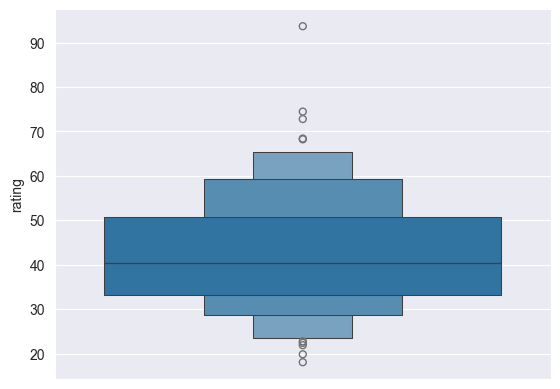

In [8]:
sns.boxenplot(cereals, y="rating")

In [5]:
cereals[cereals["rating"].arg_max()]

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,carbs
str,str,str,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
"""All-Bran with …","""K""","""C""",50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.5,93.704912,8.0


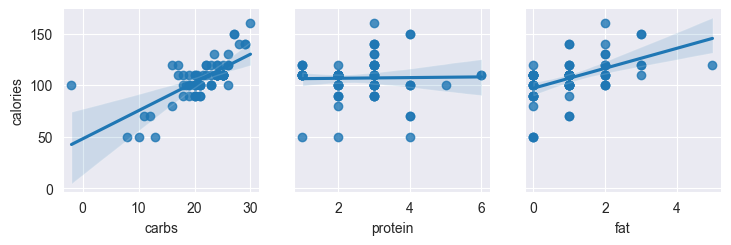

In [6]:
g = sns.PairGrid(cereals, x_vars=["carbs", "protein", "fat",], y_vars="calories")
g.map(sns.regplot);

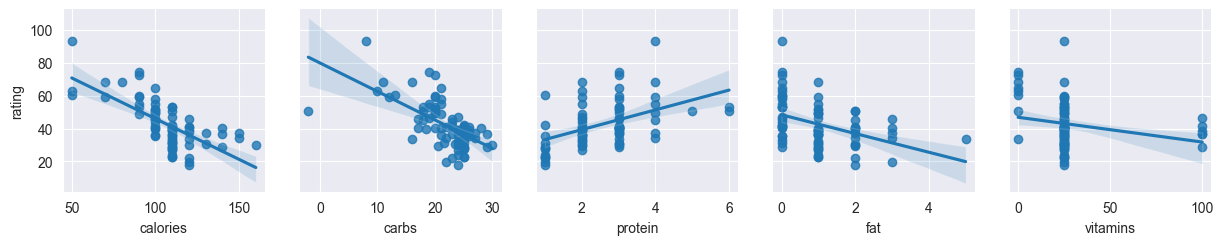

In [7]:
g = sns.PairGrid(cereals, x_vars=["calories", "carbs", "protein", "fat", "vitamins"], y_vars="rating")
g.map(sns.regplot);

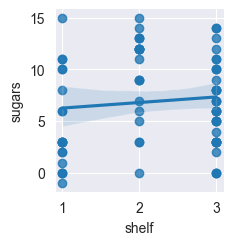

In [6]:
g = sns.PairGrid(cereals, x_vars=["shelf"], y_vars="sugars")
g.map(sns.regplot);

<Axes: xlabel='carbo', ylabel='sugars'>

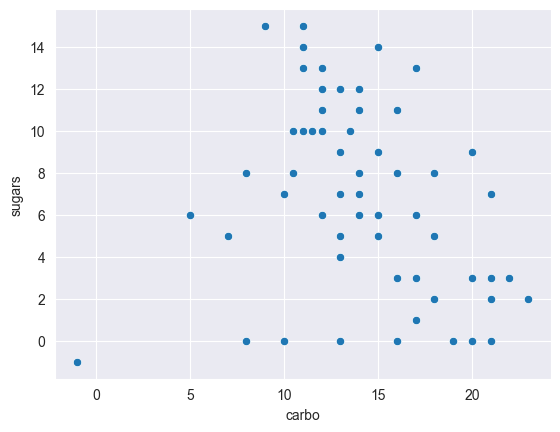

In [16]:
sns.scatterplot(cereals, x="carbo", y="sugars")